In [1]:
import pandas as pd
from math import sqrt
pd.set_option('max_colwidth', 70)
%matplotlib inline

# Simplified Uniswap Model
## Introduction to Uniswap
>Uniswap is an automated market maker for exchanging ERC20 tokens. Anyone can become a liquidity provider, and invest in the liquidity pool of an ERC20 token. This allows other users to trade that token for other tokens at an exchange rate based on their relative availibility. When a token trade is executed, a small fee is paid to the liquidity providers that enabled the transaction.
https://uniswap.io/

There are basically eight ways (_mechanisms_) in which an agent can interact with an instance of Uniswap:
1. `addLiquidity`: deposit ETH and tokens in the liquidity pool; mint UNI tokens - "shares" of that Uniswap instance - in exchange;
1. `removeLiquidity`: burn UNI tokens; withdraw a proportional amount of ETH and tokens in exchange;
1. `ethToTokenInput`: user specifies an exact amount of ETH they send; receives corresponding amount of tokens
1. `ethToTokenOutput`: user sends some ETH and specifies an exact amount of tokens they want to buy; Uniswap refunds ETH sent in excess
1. `tokenToEthInput`: user specifies an exact amount of tokens they send; receives corresponding amount of ETH
1. `tokenToEthOutput`: user specifies an exact amount of ETH they want to buy; Uniswap takes the corresponding amount of tokens from the user account
1. `tokenToTokenInput`: user specifies an exact amount of "token A" they send; receives corresponding amount of "token B" (effectively a `tokenToEthInput` in instance A combined with a `ethToTokenInput` in instance B)
1. `tokenToTokenOutput`: user specifies an exact amount of "token B˜ they want to buy; Uniswap takes the corresponding amount of "token A" from the user account (effectively a `ethToTokenOutput` in instance B combined with a `tokenToEthOutput` in instance A)

## Limitations and simplifications of this model
* When triggering mechanisms, Uniswap users may include conditions they would like to apply to the transaction. For example, they could define a minimum amount of UNI tokens they wish to receive as a result of adding liquidity to the pool; or the maximum number of tokens they are willing to pay for the amount of ETH requested in a `tokenToEthOutput` operation; or a deadline after which the transaction should not be processed. **This simplified model does not account for this kind conditioning.**

* The `ethToTokenOutput`, `tokenToEthOutput` mechanisms are not implemented. **All swaps are treated as of the "input defined" type.**

* The `tokenToToken` mechanism are not implemented, as they are merely a `tokenToEth` in the context of a single Uniswap instance.

* **User _behavior_ has not been modeled**. User _actions_ are derived from the history of events of the Uniswap instance being analyzed.

_____________

## MODEL

### Initial conditions
These are the initial conditions of the [DAI-ETH Uniswap instance](https://etherscan.io/address/0x09cabEC1eAd1c0Ba254B09efb3EE13841712bE14)

In [2]:
state = {
    'DAI_balance': 5900000000000000000000,
    'ETH_balance': 30000000000000000000
}
state['UNI_supply'] = state['ETH_balance']
state

{'DAI_balance': 5900000000000000000000,
 'ETH_balance': 30000000000000000000,
 'UNI_supply': 30000000000000000000}

### Parameters
These are the parameters of Uniswap that represent the fee collected on each swap. Notice that these are hardcoded in the Uniswap smart contracts, but we model them as parameters in order to be able to do A/B testing and parameter sweeping on them in the future.

In [3]:
params = {
    'fee_numerator': 997,
    'fee_denominator': 1000
}
params

{'fee_numerator': 997, 'fee_denominator': 1000}

### Mechanisms
In order to better mimic the behavior of Uniswap, we need to pay special attention to two things:
1. make explicit that we want numbers to be treated as integers by the Python interpreter - there are probably more casts to `int` than needed throughout the code;
1. Uniswap was coded in Vyper, where the `/` operator applied to integer variables returns the dividend of the division. In order to achieve the same in Python, we need to use _"floor division"_ (`//`) instead of _"true division"_ (`/`).

In [4]:
expr = '10000000000000000000 / 5000000000000000001'
print(f'{expr} = {eval(expr)}')
expr = 'int(10000000000000000000 / 5000000000000000001)'
print(f'{expr} = {eval(expr)}')
expr = '10000000000000000000 // 5000000000000000001'
print(f'{expr} = {eval(expr)}')

10000000000000000000 / 5000000000000000001 = 2.0
int(10000000000000000000 / 5000000000000000001) = 2
10000000000000000000 // 5000000000000000001 = 1


### Mechanism - addLiquidity

In [5]:
# def addLiquidity(min_liquidity: uint256, max_tokens: uint256, deadline: timestamp) -> uint256:
#     assert deadline > block.timestamp and (max_tokens > 0 and msg.value > 0)
#     total_liquidity: uint256 = self.totalSupply
#     if total_liquidity > 0:
#         assert min_liquidity > 0
#         eth_reserve: uint256(wei) = self.balance - msg.value
#         token_reserve: uint256 = self.token.balanceOf(self)
#         token_amount: uint256 = msg.value * token_reserve / eth_reserve + 1
#         liquidity_minted: uint256 = msg.value * total_liquidity / eth_reserve
#         assert max_tokens >= token_amount and liquidity_minted >= min_liquidity
#         self.balances[msg.sender] += liquidity_minted
#         self.totalSupply = total_liquidity + liquidity_minted
#         assert self.token.transferFrom(msg.sender, self, token_amount)
#         log.AddLiquidity(msg.sender, msg.value, token_amount)
#         log.Transfer(ZERO_ADDRESS, msg.sender, liquidity_minted)
#         return liquidity_minted

def addLiquidity_UNI(params, step, history, current_state, input_):
    total_liquidity = int(current_state['UNI_supply'])
    eth_reserve = int(current_state['ETH_balance'])
    liquidity_minted = int(input_['eth_deposit'] * total_liquidity // eth_reserve)
    return ('UNI_supply', total_liquidity + liquidity_minted)

def addLiquidity_ETH(params, step, history, current_state, input_):
    eth_reserve = int(current_state['ETH_balance'])
    return ('ETH_balance', eth_reserve + input_['eth_deposit'])

def addLiquidity_DAI(params, step, history, current_state, input_):
    eth_reserve = int(current_state['ETH_balance'])
    token_reserve = int(current_state['DAI_balance'])
    if input_['eth_deposit'] == 0:
        token_amount = 0
    else:
        token_amount = int(input_['eth_deposit'] * token_reserve // eth_reserve + 1)
    return ('DAI_balance', token_reserve + token_amount)

### Mechanism - removeLiquidity

In [6]:
# def removeLiquidity(amount: uint256, min_eth: uint256(wei), min_tokens: uint256, deadline: timestamp) -> (uint256(wei), uint256):
#     assert (amount > 0 and deadline > block.timestamp) and (min_eth > 0 and min_tokens > 0)
#     total_liquidity: uint256 = self.totalSupply
#     assert total_liquidity > 0
#     token_reserve: uint256 = self.token.balanceOf(self)
#     eth_amount: uint256(wei) = amount * self.balance / total_liquidity
#     token_amount: uint256 = amount * token_reserve / total_liquidity
#     assert eth_amount >= min_eth and token_amount >= min_tokens
#     self.balances[msg.sender] -= amount
#     self.totalSupply = total_liquidity - amount
#     send(msg.sender, eth_amount)
#     assert self.token.transfer(msg.sender, token_amount)
#     log.RemoveLiquidity(msg.sender, eth_amount, token_amount)
#     log.Transfer(msg.sender, ZERO_ADDRESS, amount)
#     return eth_amount, token_amount

def removeLiquidity_UNI(params, step, history, current_state, input_):
    total_liquidity = int(current_state['UNI_supply'])
    amount = int(input_['UNI_burn'])
    return ('UNI_supply', int(total_liquidity - amount))

def removeLiquidity_ETH(params, step, history, current_state, input_):
    total_liquidity = int(current_state['UNI_supply'])
    eth_reserve = int(current_state['ETH_balance'])
    amount = int(input_['UNI_burn'])
    eth_amount = int(amount * eth_reserve // total_liquidity)
    return ('ETH_balance', int(eth_reserve - eth_amount))

def removeLiquidity_DAI(params, step, history, current_state, input_):
    total_liquidity = int(current_state['UNI_supply'])
    token_reserve = int(current_state['DAI_balance'])
    amount = int(input_['UNI_burn'])
    token_amount = int(amount * token_reserve // total_liquidity)
    return ('DAI_balance', int(token_reserve - token_amount))

### Auxiliary function - getInputPrice

In [7]:
# @dev Pricing function for converting between ETH and Tokens.
# @param input_amount Amount of ETH or Tokens being sold.
# @param input_reserve Amount of ETH or Tokens (input type) in exchange reserves.
# @param output_reserve Amount of ETH or Tokens (output type) in exchange reserves.
# @return Amount of ETH or Tokens bought.
def getInputPrice(input_amount, input_reserve, output_reserve, params):
    fee_numerator = params['fee_numerator']
    fee_denominator = params['fee_denominator']
    input_amount_with_fee = input_amount * fee_numerator
    numerator = input_amount_with_fee * output_reserve
    denominator = (input_reserve * fee_denominator) + input_amount_with_fee
    return int(numerator // denominator)

### Mechanism - ethToToken

In [8]:
# @private
# def ethToTokenInput(eth_sold: uint256(wei), min_tokens: uint256, deadline: timestamp, buyer: address, recipient: address) -> uint256:
#     assert deadline >= block.timestamp and (eth_sold > 0 and min_tokens > 0)
#     token_reserve: uint256 = self.token.balanceOf(self)
#     tokens_bought: uint256 = self.getInputPrice(as_unitless_number(eth_sold), as_unitless_number(self.balance - eth_sold), token_reserve)
#     assert tokens_bought >= min_tokens
#     assert self.token.transfer(recipient, tokens_bought)
#     log.TokenPurchase(buyer, eth_sold, tokens_bought)
#     return tokens_bought

def ethToToken_ETH(params, step, history, current_state, input_):
    eth_sold = int(input_['eth_sold']) #amount of ETH being sold by the user
    eth_reserve = int(current_state['ETH_balance'])
    return ('ETH_balance', eth_reserve + eth_sold)

def ethToToken_DAI(params, step, history, current_state, input_):
    eth_sold = int(input_['eth_sold']) #amount of ETH being sold by the user
    eth_reserve = int(current_state['ETH_balance'])
    token_reserve = int(current_state['DAI_balance'])
    if eth_sold == 0:
        return ('DAI_balance', token_reserve)
    else:
        tokens_bought = int(getInputPrice(eth_sold, eth_reserve, token_reserve, params))
        return ('DAI_balance', token_reserve - tokens_bought)

### Mechanism - tokenToEth

In [9]:
# @private
# def tokenToEthInput(tokens_sold: uint256, min_eth: uint256(wei), deadline: timestamp, buyer: address, recipient: address) -> uint256(wei):
#     assert deadline >= block.timestamp and (tokens_sold > 0 and min_eth > 0)
#     token_reserve: uint256 = self.token.balanceOf(self)
#     eth_bought: uint256 = self.getInputPrice(tokens_sold, token_reserve, as_unitless_number(self.balance))
#     wei_bought: uint256(wei) = as_wei_value(eth_bought, 'wei')
#     assert wei_bought >= min_eth
#     send(recipient, wei_bought)
#     assert self.token.transferFrom(buyer, self, tokens_sold)
#     log.EthPurchase(buyer, tokens_sold, wei_bought)
#     return wei_bought

def tokenToEth_ETH(params, step, history, current_state, input_):
    tokens_sold = int(input_['tokens_sold']) #amount of tokens being sold by the user
    eth_reserve = int(current_state['ETH_balance'])
    if tokens_sold == 0:
        return ('ETH_balance', eth_reserve)
    else:
        token_reserve = int(current_state['DAI_balance'])
        eth_bought = int(getInputPrice(tokens_sold, token_reserve, eth_reserve, params))
        return ('ETH_balance', eth_reserve - eth_bought)
    
def tokenToEth_DAI(params, step, history, current_state, input_):
    tokens_sold = int(input_['tokens_sold']) #amount of tokens being sold by the user
    token_reserve = int(current_state['DAI_balance'])
    return ('DAI_balance', token_reserve + tokens_sold)

### Events dataset
The events dataset was generated using [Kaggle/BigQuery](https://www.kaggle.com/markusbkoch/uniswap-ethdai-exchange/), as is available for download [here](https://www.kaggleusercontent.com/kf/21051736/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..HdZwILo7rBzA0baBSYIogA.5sWqgw2JU7MhBWp6MFRE2kpUJPQyAsOmljPX3jRGeEJMY5bYdZNjeW6XsuOkVDe8v4wcL5Efa3EpkrrC7bu-RLKqEEHazP2L5IQHGoYhschgBumjaoR2VPGM4xL40abyFTesKlVHGef2EIIlwpvHX0DcNrMQI-MpyVEjMSHx_oY.kBNFGv1rap1qLe-tfqQA6A/uniswap_events.pickle).

In [10]:
uniswap_events = pd.read_pickle('uniswap_events.pickle')
uniswap_events

,transactionHash,transaction_index,transaction_sender,address,data,topics,block_timestamp,blockNumber_dec,contract,event,contract_event,block_group,agent,eth_delta,token_delta,uni_delta,eth_balance,token_balance,UNI_supply,invariant
0,0xbd773ccc33c831378f2aa2b7d4a9ae8a20ed9112ea9acb86ce96aa674c0cb5f9,150,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0x06239653922ac7bea6aa2b19dc486b9361821d37712eb796adfd38d81de278c...,2018-11-02 10:27:36+00:00,6629139,DAI,AddLiquidity,DAIAddLiquidity,662,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,30000000000000000000,5900000000000000000000,0,30000000000000000000,5900000000000000000000,0,177000000000000000000000000000000000000000
1,0xbd773ccc33c831378f2aa2b7d4a9ae8a20ed9112ea9acb86ce96aa674c0cb5f9,150,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x000000000000000000000000000000000000000000000001a055690d9db80000,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3e...,2018-11-02 10:27:36+00:00,6629139,DAI,Transfer,DAITransfer,662,0x0000000000000000000000000000000000000000,0,0,30000000000000000000,30000000000000000000,5900000000000000000000,30000000000000000000,177000000000000000000000000000000000000000
2,0xd53f01fc0cabbf4083da93a023ddb81de91320027077849ac982f7bc04b49279,97,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0x7f4091b46c33e918a0f3aa42307641d17bb67029427a5369e54b35398423870...,2018-11-02 10:33:56+00:00,6629171,DAI,EthPurchase,DAIEthPurchase,662,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,-25326059253325791,5000000000000000000,0,29974673940746674209,5905000000000000000000,30000000000000000000,177000449620109111204145000000000000000000
3,0x53172898dbe437c784f7e4ac757087b28d1b06aa6b72b81d4a6bb2bead50c93e,53,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0x7f4091b46c33e918a0f3aa42307641d17bb67029427a5369e54b35398423870...,2018-11-02 10:35:47+00:00,6629177,DAI,EthPurchase,DAIEthPurchase,662,0xf369af914dbed0ad7afdddebc631ee0fda1b4891,-10118429075406013,2000000000000000000,0,29964555511671268196,5907000000000000000000,30000000000000000000,177000629407442181233772000000000000000000
4,0x6cef57fd37d7a2602c1236ff080c61c37e10980c7e3bd66de6f4e0ed52f16011,24,0x11e4857bb9993a50c685a79afad4e6f65d518dda,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0xcd60aa75dea3072fbc07ae6d7d856b5dc5f4eee88854f5b4abf7b680ef8bc50...,2018-11-02 10:38:18+00:00,6629190,DAI,TokenPurchase,DAITokenPurchase,662,0x11e4857bb9993a50c685a79afad4e6f65d518dda,10000000000000000,-1964761376358359468,0,29974555511671268196,5905035238623641640532,30000000000000000000,177000806558499339943044863018842396120272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101481,0xe9286e3e23957063046d6299eca0a5c724a034a0566a78754f5f23613a4b0312,40,0x4b8673ca1b5c9f08cfffce527fec9173c35e27f3,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0x7f4091b46c33e918a0f3aa42307641d17bb67029427a5369e54b35398423870...,2019-09-23 23:37:04+00:00,8608422,DAI,EthPurchase,DAIEthPurchase,860,0x4b8673ca1b5c9f08cfffce527fec9173c35e27f3,-198016436809685891,40000000000000000000,0,6302047541877387309207,1269256071848791636644352,5320135262833503868378,7998912107607625827109961968988225660114148864
101482,0x3f5265badf1846d559337e655faf03e643f36599aded1ea233b5eb6928219804,83,0x4b8673ca1b5c9f08cfffce527fec9173c35e27f3,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,[0x7f4091b46c33e918a0f3aa42307641d17bb67029427a5369e54b35398423870...,2019-09-23 23:45:05+00:00,8608464,DAI,EthPurchase,DAIEthPurchase,860,0x4b8673ca1b5c9f08cfffce527fec9173c35e27f3,-123753942543874669,25000000000000000000,0,6301923787934843434538,1269281071848791636644352,5320135262833503868378,7998912580259335158776901047006760160899429376
101483,0x6f1ce2ac600b615a9a99729100cafb9e8c6a5b592b5c26de8be8a7998c4780ca,108,0x23983ea2123d40eb5655dfff3f3c917c78f214f6,0x09cabec1ead1c0ba254b09efb3ee13841712be14,0x,

### Policy function - user action
In this simplified model of Uniswap, we have not modeled user behavior. Instead, we map events to actions.

In [11]:
def actionDecoder(params, step, history, current_state):
    
    prev_timestep = current_state['timestep']
    if step > 1:
        prev_timestep -= 1
        
    #skip the first two events, as they are already accounted for in the initial conditions of the system
    data_counter = prev_timestep + 2 
    
    action = {
        'eth_sold': 0,
        'tokens_sold': 0,
        'eth_deposit': 0,
        'UNI_burn': 0,        
    }
    
    event = uniswap_events['event'][data_counter]
    
    action['action_id'] = event
    
    if event == 'TokenPurchase':
        action['eth_sold'] = uniswap_events['eth_delta'][data_counter]
    elif event == 'EthPurchase':
        action['tokens_sold'] = uniswap_events['token_delta'][data_counter]
    elif event == 'AddLiquidity':
        action['eth_deposit'] = uniswap_events['eth_delta'][data_counter]
    elif event == 'Transfer':
        UNI_delta = uniswap_events['uni_delta'][data_counter]
        if UNI_delta < 0:
            action['UNI_burn'] = -UNI_delta

    return action

### Partial state update blocks
Now that we have mapped the events in the history dataset to user action in our model, we need a "hub" state update function for each one of the state variables. The hub checks the action being performed and calls the corresponding state update function of the mechanism

In [12]:
def mechanismHub_DAI(params, step, history, current_state, input_):
    action = input_['action_id']
    if action == 'TokenPurchase':
        return ethToToken_DAI(params, step, history, current_state, input_)
    elif action == 'EthPurchase':
        return tokenToEth_DAI(params, step, history, current_state, input_)
    elif action == 'AddLiquidity':
        return addLiquidity_DAI(params, step, history, current_state, input_)
    elif action == 'Transfer':
        return removeLiquidity_DAI(params, step, history, current_state, input_)
    return('DAI_balance', current_state['DAI_balance'])
    
def mechanismHub_ETH(params, step, history, current_state, input_):
    action = input_['action_id']
    if action == 'TokenPurchase':
        return ethToToken_ETH(params, step, history, current_state, input_)
    elif action == 'EthPurchase':
        return tokenToEth_ETH(params, step, history, current_state, input_)
    elif action == 'AddLiquidity':
        return addLiquidity_ETH(params, step, history, current_state, input_)
    elif action == 'Transfer':
        return removeLiquidity_ETH(params, step, history, current_state, input_)
    return('ETH_balance', current_state['ETH_balance'])

def mechanismHub_UNI(params, step, history, current_state, input_):
    action = input_['action_id']
    if action == 'AddLiquidity':
        return addLiquidity_UNI(params, step, history, current_state, input_)
    elif action == 'Transfer':
        return removeLiquidity_UNI(params, step, history, current_state, input_)
    return('UNI_supply', current_state['UNI_supply'])
    

Finally, we define the list of Partial State Update Blocks - in this case, a single PSUB

In [13]:
PSUBs = [
    {
        'policies': {
            'user_action': actionDecoder
        },
        'variables': {
            'DAI_balance': mechanismHub_DAI,
            'ETH_balance': mechanismHub_ETH,
            'UNI_supply': mechanismHub_UNI
        }
    }
]

In [14]:
# the number of timesteps in our simulation is the length of the events dataset minus the first two events
# as they are already accounted for in the initial conditions of the system
simulation_parameters = {
    'T': range(len(uniswap_events)-2),
    'N': 1,
    'M': params
}

In [15]:
from cadCAD.configuration import Configuration

config = Configuration(initial_state=state,
                       partial_state_update_blocks=PSUBs, 
                       sim_config=simulation_parameters 
                      )

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.multi_proc)
executor = Executor(exec_context, [config])
raw_result, tensor = executor.execute()[0]

df = pd.DataFrame(raw_result)


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x10b595e10>]
Configurations: [<cadCAD.configuration.Configuration object at 0x10b595e10>]
time: 0
time: 10
time: 20
time: 30
time: 40
time: 50
time: 60
time: 70
time: 80
time: 90
time: 100
time: 110
time: 120
time: 130
time: 140
time: 150
time: 160
time: 170
time: 180
time: 190
time: 200
time: 210
time: 220
time: 230
time: 240
time: 250
time: 260
time: 270
time: 280
time: 290
time: 300
time: 310
time: 320
time: 330
time: 340
time: 350
time: 360
time: 370
time: 380
time: 390
time: 400
time: 410
time: 420
time: 430
time: 440
time: 450
time: 460
time: 470
time: 480
time: 490
time: 500
time: 510
time: 520
time: 530
time: 540
time: 550
time: 560
time: 

time: 6260
time: 6270
time: 6280
time: 6290
time: 6300
time: 6310
time: 6320
time: 6330
time: 6340
time: 6350
time: 6360
time: 6370
time: 6380
time: 6390
time: 6400
time: 6410
time: 6420
time: 6430
time: 6440
time: 6450
time: 6460
time: 6470
time: 6480
time: 6490
time: 6500
time: 6510
time: 6520
time: 6530
time: 6540
time: 6550
time: 6560
time: 6570
time: 6580
time: 6590
time: 6600
time: 6610
time: 6620
time: 6630
time: 6640
time: 6650
time: 6660
time: 6670
time: 6680
time: 6690
time: 6700
time: 6710
time: 6720
time: 6730
time: 6740
time: 6750
time: 6760
time: 6770
time: 6780
time: 6790
time: 6800
time: 6810
time: 6820
time: 6830
time: 6840
time: 6850
time: 6860
time: 6870
time: 6880
time: 6890
time: 6900
time: 6910
time: 6920
time: 6930
time: 6940
time: 6950
time: 6960
time: 6970
time: 6980
time: 6990
time: 7000
time: 7010
time: 7020
time: 7030
time: 7040
time: 7050
time: 7060
time: 7070
time: 7080
time: 7090
time: 7100
time: 7110
time: 7120
time: 7130
time: 7140
time: 7150
time: 7160

time: 13400
time: 13410
time: 13420
time: 13430
time: 13440
time: 13450
time: 13460
time: 13470
time: 13480
time: 13490
time: 13500
time: 13510
time: 13520
time: 13530
time: 13540
time: 13550
time: 13560
time: 13570
time: 13580
time: 13590
time: 13600
time: 13610
time: 13620
time: 13630
time: 13640
time: 13650
time: 13660
time: 13670
time: 13680
time: 13690
time: 13700
time: 13710
time: 13720
time: 13730
time: 13740
time: 13750
time: 13760
time: 13770
time: 13780
time: 13790
time: 13800
time: 13810
time: 13820
time: 13830
time: 13840
time: 13850
time: 13860
time: 13870
time: 13880
time: 13890
time: 13900
time: 13910
time: 13920
time: 13930
time: 13940
time: 13950
time: 13960
time: 13970
time: 13980
time: 13990
time: 14000
time: 14010
time: 14020
time: 14030
time: 14040
time: 14050
time: 14060
time: 14070
time: 14080
time: 14090
time: 14100
time: 14110
time: 14120
time: 14130
time: 14140
time: 14150
time: 14160
time: 14170
time: 14180
time: 14190
time: 14200
time: 14210
time: 14220
time

time: 20230
time: 20240
time: 20250
time: 20260
time: 20270
time: 20280
time: 20290
time: 20300
time: 20310
time: 20320
time: 20330
time: 20340
time: 20350
time: 20360
time: 20370
time: 20380
time: 20390
time: 20400
time: 20410
time: 20420
time: 20430
time: 20440
time: 20450
time: 20460
time: 20470
time: 20480
time: 20490
time: 20500
time: 20510
time: 20520
time: 20530
time: 20540
time: 20550
time: 20560
time: 20570
time: 20580
time: 20590
time: 20600
time: 20610
time: 20620
time: 20630
time: 20640
time: 20650
time: 20660
time: 20670
time: 20680
time: 20690
time: 20700
time: 20710
time: 20720
time: 20730
time: 20740
time: 20750
time: 20760
time: 20770
time: 20780
time: 20790
time: 20800
time: 20810
time: 20820
time: 20830
time: 20840
time: 20850
time: 20860
time: 20870
time: 20880
time: 20890
time: 20900
time: 20910
time: 20920
time: 20930
time: 20940
time: 20950
time: 20960
time: 20970
time: 20980
time: 20990
time: 21000
time: 21010
time: 21020
time: 21030
time: 21040
time: 21050
time

time: 27060
time: 27070
time: 27080
time: 27090
time: 27100
time: 27110
time: 27120
time: 27130
time: 27140
time: 27150
time: 27160
time: 27170
time: 27180
time: 27190
time: 27200
time: 27210
time: 27220
time: 27230
time: 27240
time: 27250
time: 27260
time: 27270
time: 27280
time: 27290
time: 27300
time: 27310
time: 27320
time: 27330
time: 27340
time: 27350
time: 27360
time: 27370
time: 27380
time: 27390
time: 27400
time: 27410
time: 27420
time: 27430
time: 27440
time: 27450
time: 27460
time: 27470
time: 27480
time: 27490
time: 27500
time: 27510
time: 27520
time: 27530
time: 27540
time: 27550
time: 27560
time: 27570
time: 27580
time: 27590
time: 27600
time: 27610
time: 27620
time: 27630
time: 27640
time: 27650
time: 27660
time: 27670
time: 27680
time: 27690
time: 27700
time: 27710
time: 27720
time: 27730
time: 27740
time: 27750
time: 27760
time: 27770
time: 27780
time: 27790
time: 27800
time: 27810
time: 27820
time: 27830
time: 27840
time: 27850
time: 27860
time: 27870
time: 27880
time

time: 33890
time: 33900
time: 33910
time: 33920
time: 33930
time: 33940
time: 33950
time: 33960
time: 33970
time: 33980
time: 33990
time: 34000
time: 34010
time: 34020
time: 34030
time: 34040
time: 34050
time: 34060
time: 34070
time: 34080
time: 34090
time: 34100
time: 34110
time: 34120
time: 34130
time: 34140
time: 34150
time: 34160
time: 34170
time: 34180
time: 34190
time: 34200
time: 34210
time: 34220
time: 34230
time: 34240
time: 34250
time: 34260
time: 34270
time: 34280
time: 34290
time: 34300
time: 34310
time: 34320
time: 34330
time: 34340
time: 34350
time: 34360
time: 34370
time: 34380
time: 34390
time: 34400
time: 34410
time: 34420
time: 34430
time: 34440
time: 34450
time: 34460
time: 34470
time: 34480
time: 34490
time: 34500
time: 34510
time: 34520
time: 34530
time: 34540
time: 34550
time: 34560
time: 34570
time: 34580
time: 34590
time: 34600
time: 34610
time: 34620
time: 34630
time: 34640
time: 34650
time: 34660
time: 34670
time: 34680
time: 34690
time: 34700
time: 34710
time

time: 40720
time: 40730
time: 40740
time: 40750
time: 40760
time: 40770
time: 40780
time: 40790
time: 40800
time: 40810
time: 40820
time: 40830
time: 40840
time: 40850
time: 40860
time: 40870
time: 40880
time: 40890
time: 40900
time: 40910
time: 40920
time: 40930
time: 40940
time: 40950
time: 40960
time: 40970
time: 40980
time: 40990
time: 41000
time: 41010
time: 41020
time: 41030
time: 41040
time: 41050
time: 41060
time: 41070
time: 41080
time: 41090
time: 41100
time: 41110
time: 41120
time: 41130
time: 41140
time: 41150
time: 41160
time: 41170
time: 41180
time: 41190
time: 41200
time: 41210
time: 41220
time: 41230
time: 41240
time: 41250
time: 41260
time: 41270
time: 41280
time: 41290
time: 41300
time: 41310
time: 41320
time: 41330
time: 41340
time: 41350
time: 41360
time: 41370
time: 41380
time: 41390
time: 41400
time: 41410
time: 41420
time: 41430
time: 41440
time: 41450
time: 41460
time: 41470
time: 41480
time: 41490
time: 41500
time: 41510
time: 41520
time: 41530
time: 41540
time

time: 47550
time: 47560
time: 47570
time: 47580
time: 47590
time: 47600
time: 47610
time: 47620
time: 47630
time: 47640
time: 47650
time: 47660
time: 47670
time: 47680
time: 47690
time: 47700
time: 47710
time: 47720
time: 47730
time: 47740
time: 47750
time: 47760
time: 47770
time: 47780
time: 47790
time: 47800
time: 47810
time: 47820
time: 47830
time: 47840
time: 47850
time: 47860
time: 47870
time: 47880
time: 47890
time: 47900
time: 47910
time: 47920
time: 47930
time: 47940
time: 47950
time: 47960
time: 47970
time: 47980
time: 47990
time: 48000
time: 48010
time: 48020
time: 48030
time: 48040
time: 48050
time: 48060
time: 48070
time: 48080
time: 48090
time: 48100
time: 48110
time: 48120
time: 48130
time: 48140
time: 48150
time: 48160
time: 48170
time: 48180
time: 48190
time: 48200
time: 48210
time: 48220
time: 48230
time: 48240
time: 48250
time: 48260
time: 48270
time: 48280
time: 48290
time: 48300
time: 48310
time: 48320
time: 48330
time: 48340
time: 48350
time: 48360
time: 48370
time

time: 54380
time: 54390
time: 54400
time: 54410
time: 54420
time: 54430
time: 54440
time: 54450
time: 54460
time: 54470
time: 54480
time: 54490
time: 54500
time: 54510
time: 54520
time: 54530
time: 54540
time: 54550
time: 54560
time: 54570
time: 54580
time: 54590
time: 54600
time: 54610
time: 54620
time: 54630
time: 54640
time: 54650
time: 54660
time: 54670
time: 54680
time: 54690
time: 54700
time: 54710
time: 54720
time: 54730
time: 54740
time: 54750
time: 54760
time: 54770
time: 54780
time: 54790
time: 54800
time: 54810
time: 54820
time: 54830
time: 54840
time: 54850
time: 54860
time: 54870
time: 54880
time: 54890
time: 54900
time: 54910
time: 54920
time: 54930
time: 54940
time: 54950
time: 54960
time: 54970
time: 54980
time: 54990
time: 55000
time: 55010
time: 55020
time: 55030
time: 55040
time: 55050
time: 55060
time: 55070
time: 55080
time: 55090
time: 55100
time: 55110
time: 55120
time: 55130
time: 55140
time: 55150
time: 55160
time: 55170
time: 55180
time: 55190
time: 55200
time

time: 61210
time: 61220
time: 61230
time: 61240
time: 61250
time: 61260
time: 61270
time: 61280
time: 61290
time: 61300
time: 61310
time: 61320
time: 61330
time: 61340
time: 61350
time: 61360
time: 61370
time: 61380
time: 61390
time: 61400
time: 61410
time: 61420
time: 61430
time: 61440
time: 61450
time: 61460
time: 61470
time: 61480
time: 61490
time: 61500
time: 61510
time: 61520
time: 61530
time: 61540
time: 61550
time: 61560
time: 61570
time: 61580
time: 61590
time: 61600
time: 61610
time: 61620
time: 61630
time: 61640
time: 61650
time: 61660
time: 61670
time: 61680
time: 61690
time: 61700
time: 61710
time: 61720
time: 61730
time: 61740
time: 61750
time: 61760
time: 61770
time: 61780
time: 61790
time: 61800
time: 61810
time: 61820
time: 61830
time: 61840
time: 61850
time: 61860
time: 61870
time: 61880
time: 61890
time: 61900
time: 61910
time: 61920
time: 61930
time: 61940
time: 61950
time: 61960
time: 61970
time: 61980
time: 61990
time: 62000
time: 62010
time: 62020
time: 62030
time

time: 68040
time: 68050
time: 68060
time: 68070
time: 68080
time: 68090
time: 68100
time: 68110
time: 68120
time: 68130
time: 68140
time: 68150
time: 68160
time: 68170
time: 68180
time: 68190
time: 68200
time: 68210
time: 68220
time: 68230
time: 68240
time: 68250
time: 68260
time: 68270
time: 68280
time: 68290
time: 68300
time: 68310
time: 68320
time: 68330
time: 68340
time: 68350
time: 68360
time: 68370
time: 68380
time: 68390
time: 68400
time: 68410
time: 68420
time: 68430
time: 68440
time: 68450
time: 68460
time: 68470
time: 68480
time: 68490
time: 68500
time: 68510
time: 68520
time: 68530
time: 68540
time: 68550
time: 68560
time: 68570
time: 68580
time: 68590
time: 68600
time: 68610
time: 68620
time: 68630
time: 68640
time: 68650
time: 68660
time: 68670
time: 68680
time: 68690
time: 68700
time: 68710
time: 68720
time: 68730
time: 68740
time: 68750
time: 68760
time: 68770
time: 68780
time: 68790
time: 68800
time: 68810
time: 68820
time: 68830
time: 68840
time: 68850
time: 68860
time

time: 74870
time: 74880
time: 74890
time: 74900
time: 74910
time: 74920
time: 74930
time: 74940
time: 74950
time: 74960
time: 74970
time: 74980
time: 74990
time: 75000
time: 75010
time: 75020
time: 75030
time: 75040
time: 75050
time: 75060
time: 75070
time: 75080
time: 75090
time: 75100
time: 75110
time: 75120
time: 75130
time: 75140
time: 75150
time: 75160
time: 75170
time: 75180
time: 75190
time: 75200
time: 75210
time: 75220
time: 75230
time: 75240
time: 75250
time: 75260
time: 75270
time: 75280
time: 75290
time: 75300
time: 75310
time: 75320
time: 75330
time: 75340
time: 75350
time: 75360
time: 75370
time: 75380
time: 75390
time: 75400
time: 75410
time: 75420
time: 75430
time: 75440
time: 75450
time: 75460
time: 75470
time: 75480
time: 75490
time: 75500
time: 75510
time: 75520
time: 75530
time: 75540
time: 75550
time: 75560
time: 75570
time: 75580
time: 75590
time: 75600
time: 75610
time: 75620
time: 75630
time: 75640
time: 75650
time: 75660
time: 75670
time: 75680
time: 75690
time

time: 81700
time: 81710
time: 81720
time: 81730
time: 81740
time: 81750
time: 81760
time: 81770
time: 81780
time: 81790
time: 81800
time: 81810
time: 81820
time: 81830
time: 81840
time: 81850
time: 81860
time: 81870
time: 81880
time: 81890
time: 81900
time: 81910
time: 81920
time: 81930
time: 81940
time: 81950
time: 81960
time: 81970
time: 81980
time: 81990
time: 82000
time: 82010
time: 82020
time: 82030
time: 82040
time: 82050
time: 82060
time: 82070
time: 82080
time: 82090
time: 82100
time: 82110
time: 82120
time: 82130
time: 82140
time: 82150
time: 82160
time: 82170
time: 82180
time: 82190
time: 82200
time: 82210
time: 82220
time: 82230
time: 82240
time: 82250
time: 82260
time: 82270
time: 82280
time: 82290
time: 82300
time: 82310
time: 82320
time: 82330
time: 82340
time: 82350
time: 82360
time: 82370
time: 82380
time: 82390
time: 82400
time: 82410
time: 82420
time: 82430
time: 82440
time: 82450
time: 82460
time: 82470
time: 82480
time: 82490
time: 82500
time: 82510
time: 82520
time

time: 88530
time: 88540
time: 88550
time: 88560
time: 88570
time: 88580
time: 88590
time: 88600
time: 88610
time: 88620
time: 88630
time: 88640
time: 88650
time: 88660
time: 88670
time: 88680
time: 88690
time: 88700
time: 88710
time: 88720
time: 88730
time: 88740
time: 88750
time: 88760
time: 88770
time: 88780
time: 88790
time: 88800
time: 88810
time: 88820
time: 88830
time: 88840
time: 88850
time: 88860
time: 88870
time: 88880
time: 88890
time: 88900
time: 88910
time: 88920
time: 88930
time: 88940
time: 88950
time: 88960
time: 88970
time: 88980
time: 88990
time: 89000
time: 89010
time: 89020
time: 89030
time: 89040
time: 89050
time: 89060
time: 89070
time: 89080
time: 89090
time: 89100
time: 89110
time: 89120
time: 89130
time: 89140
time: 89150
time: 89160
time: 89170
time: 89180
time: 89190
time: 89200
time: 89210
time: 89220
time: 89230
time: 89240
time: 89250
time: 89260
time: 89270
time: 89280
time: 89290
time: 89300
time: 89310
time: 89320
time: 89330
time: 89340
time: 89350
time

time: 95360
time: 95370
time: 95380
time: 95390
time: 95400
time: 95410
time: 95420
time: 95430
time: 95440
time: 95450
time: 95460
time: 95470
time: 95480
time: 95490
time: 95500
time: 95510
time: 95520
time: 95530
time: 95540
time: 95550
time: 95560
time: 95570
time: 95580
time: 95590
time: 95600
time: 95610
time: 95620
time: 95630
time: 95640
time: 95650
time: 95660
time: 95670
time: 95680
time: 95690
time: 95700
time: 95710
time: 95720
time: 95730
time: 95740
time: 95750
time: 95760
time: 95770
time: 95780
time: 95790
time: 95800
time: 95810
time: 95820
time: 95830
time: 95840
time: 95850
time: 95860
time: 95870
time: 95880
time: 95890
time: 95900
time: 95910
time: 95920
time: 95930
time: 95940
time: 95950
time: 95960
time: 95970
time: 95980
time: 95990
time: 96000
time: 96010
time: 96020
time: 96030
time: 96040
time: 96050
time: 96060
time: 96070
time: 96080
time: 96090
time: 96100
time: 96110
time: 96120
time: 96130
time: 96140
time: 96150
time: 96160
time: 96170
time: 96180
time

_____________

## ANALYSIS

In [16]:
model_history = df[['DAI_balance', 'ETH_balance', 'UNI_supply']]
model_history.columns = ['model_DAI_balance', 'model_ETH_balance', 'model_UNI_supply']

In [17]:
real_history = uniswap_events.iloc[1:][['token_balance','eth_balance','UNI_supply']].reset_index(drop=True)
real_history.columns = ['real_DAI_balance', 'real_ETH_balance', 'real_UNI_supply']

Despite the simplifications, the outputs of the model are very similar to the real data

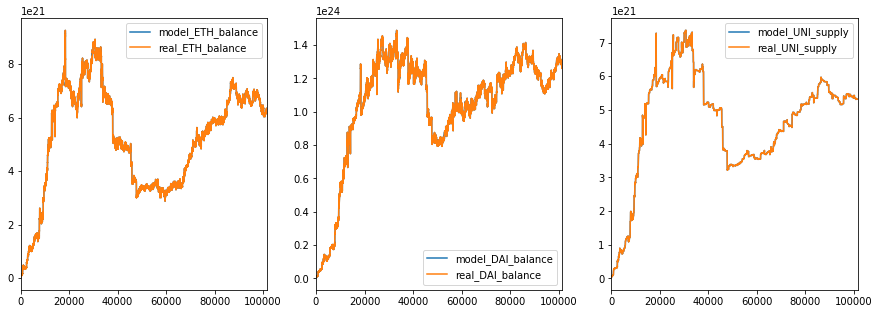

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
ax = plt.subplot(131)
model_history.astype(float).plot(ax=ax, y=['model_ETH_balance'])
real_history.astype(float).plot(ax=ax, y=['real_ETH_balance'])
ax = plt.subplot(132)
model_history.astype(float).plot(ax=ax, y=['model_DAI_balance'])
real_history.astype(float).plot(ax=ax, y=['real_DAI_balance'])
ax = plt.subplot(133)
model_history.astype(float).plot(ax=ax, y=['model_UNI_supply'])
real_history.astype(float).plot(ax=ax, y=['real_UNI_supply'])

Only if we look much more closely can we see some deviation

In [19]:
model_history.tail(1)

,model_DAI_balance,model_ETH_balance,model_UNI_supply
101484,1268445487370480899199906,6306058808358170889735,5320123300661846672003


In [20]:
real_history.tail(1)

,real_DAI_balance,real_ETH_balance,real_UNI_supply
101484,1268456444556868663822658,6306033015368245238058,5320135262833503868378


In [21]:
model_history.iloc[-1]['model_DAI_balance']/real_history.iloc[-1]['real_DAI_balance']

0.9999913617953263

In [22]:
model_history.iloc[-1]['model_ETH_balance']/real_history.iloc[-1]['real_ETH_balance']

1.0000040902085134

In [23]:
model_history.iloc[-1]['model_UNI_supply']/real_history.iloc[-1]['real_UNI_supply']

0.9999977515286612

_____________

## Model v2
In this version of the model, we modify the policy function in such a way that we don't merely repeat the actions that the traders took in the history of Uniswap. Instead, we assume that traders intend to move the spot price of the Uniswap instance to a specified value - the same value they actually moved the price to in the history of Uniswap.

This is very similar to mimicking the past actions of the traders. Indeed, we should see approximately the same results as the ones we had in the previous simulation. But this model will allow us to build more sophisticated models and simulations in the next step.

In [28]:
def actionDecoder(params, step, history, current_state):

    def getInputFromFinalSpotPrice(spot_price, input_reserve, output_reserve, params):
        a = params['fee_numerator']
        b = params['fee_denominator']
        I = input_reserve
        O = output_reserve
        P = spot_price
        input_amount = - (a*I*P + b*I*P - sqrt(a**2 * I**2 * P**2 - 
                                               2 * a * b * I**2 * P**2 + 
                                               b**2 * I**2 * P**2 +
                                               4 * a * b * O * I * P)) / (2*a*P) 
        return input_amount


    prev_timestep = current_state['timestep']
    if step > 1:
        prev_timestep -= 1
    if prev_timestep % 10 == 0:
        print(f'time: {prev_timestep}')
    #skip the first two events, as they are already accounted for in the initial conditions of the system
    data_counter = prev_timestep + 2 
    
    action = {
        'eth_sold': 0,
        'tokens_sold': 0,
        'eth_deposit': 0,
        'UNI_burn': 0,        
    }
    
    event = uniswap_events['event'][data_counter]
    
    action['action_id'] = event
    
    if event == 'TokenPurchase':
        R_i = current_state['ETH_balance']
        R_o = current_state['DAI_balance']
        sp = uniswap_events['token_balance'][data_counter] / uniswap_events['eth_balance'][data_counter]
        action['eth_sold'] = getInputFromFinalSpotPrice(sp, R_i, R_o, params)
    elif event == 'EthPurchase':
        R_i = current_state['DAI_balance']
        R_o = current_state['ETH_balance']
        sp = uniswap_events['eth_balance'][data_counter] / uniswap_events['token_balance'][data_counter]
        action['tokens_sold'] = getInputFromFinalSpotPrice(sp, R_i, R_o, params)
    elif event == 'AddLiquidity':
        action['eth_deposit'] = uniswap_events['eth_delta'][data_counter]
    elif event == 'Transfer':
        UNI_delta = uniswap_events['uni_delta'][data_counter]
        if UNI_delta < 0:
            action['UNI_burn'] = -UNI_delta

    return action

In [29]:
PSUBs = [
    {
        'policies': {
            'user_action': actionDecoder
        },
        'variables': {
            'DAI_balance': mechanismHub_DAI,
            'ETH_balance': mechanismHub_ETH,
            'UNI_supply': mechanismHub_UNI
        }
    }
]

In [56]:
# the number of timesteps in our simulation is the length of the events dataset minus the first two events
# as they are already accounted for in the initial conditions of the system
simulation_parameters = {
    'T': range(len(uniswap_events)-2),
#     'T': range(1000),
    'N': 1,
    'M': params
}

In [57]:
from cadCAD.configuration import Configuration

config = Configuration(initial_state=state,
                       partial_state_update_blocks=PSUBs, 
                       sim_config=simulation_parameters 
                      )

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.multi_proc)
executor = Executor(exec_context, [config])
raw_result, tensor = executor.execute()[0]

df = pd.DataFrame(raw_result)


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x1139c0978>]
Configurations: [<cadCAD.configuration.Configuration object at 0x1139c0978>]


_____________

## ANALYSIS

In [58]:
model_history = df[['DAI_balance', 'ETH_balance', 'UNI_supply']]
model_history.columns = ['model_DAI_balance', 'model_ETH_balance', 'model_UNI_supply']

In [59]:
real_history = uniswap_events.iloc[1:][['token_balance','eth_balance','UNI_supply']].reset_index(drop=True)
real_history.columns = ['real_DAI_balance', 'real_ETH_balance', 'real_UNI_supply']

Despite the simplifications, the outputs of the model are very similar to the real data

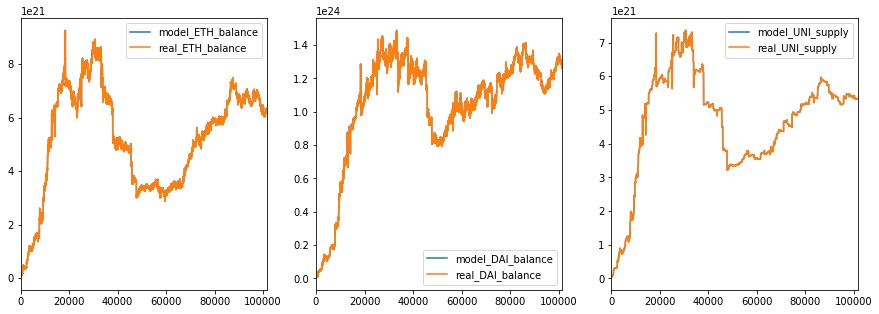

In [69]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
ax = plt.subplot(131)
model_history.astype(float).plot(ax=ax, y=['model_ETH_balance'])
real_history.astype(float).plot(ax=ax, y=['real_ETH_balance'])
ax = plt.subplot(132)
model_history.astype(float).plot(ax=ax, y=['model_DAI_balance'])
real_history.astype(float).plot(ax=ax, y=['real_DAI_balance'])
ax = plt.subplot(133)
model_history.astype(float).plot(ax=ax, y=['model_UNI_supply'])
real_history.astype(float).plot(ax=ax, y=['real_UNI_supply'])

Only if we look much more closely can we see some deviation

In [61]:
model_history.tail(1)

,model_DAI_balance,model_ETH_balance,model_UNI_supply
101484,1268456528584669092156778,6306033433105949044024,5320135546652624442495


In [62]:
real_history.tail(1)

,real_DAI_balance,real_ETH_balance,real_UNI_supply
101484,1268456444556868663822658,6306033015368245238058,5320135262833503868378


In [63]:
model_history.iloc[-1]['model_DAI_balance']/real_history.iloc[-1]['real_DAI_balance']

1.0000000662441353

In [64]:
model_history.iloc[-1]['model_ETH_balance']/real_history.iloc[-1]['real_ETH_balance']

1.0000000662441353

In [65]:
model_history.iloc[-1]['model_UNI_supply']/real_history.iloc[-1]['real_UNI_supply']

1.0000000533481024